# Analysis of sentiments
***

# 0.0 Context


## 0.1 About the Dataset

This dataset was taken from the social network Twitter and is divided into three classes (positive, negative and neutral). These dataset have a popular language with slang and word abbreviations. It is necessary to perform some manipulations on the data to obtain a better performance of the model used.

Sentiments labels were transformed as follow:
- Negative label: 0
- Positive label: 1
- Neutral label: 2

## 0.2 Columns Description

- <b>id:</b> String identifier directly from Twitter;
- <b>tweet_text:</b> Full text from the tweet
- <b>tweet_date:</b> Tweet creation date
- <b>sentiment:</b> Sentiment label (classifier)
- <b>query_used:</b> Query used to collect the tweet

# 1.0 Imports

In [1]:
import re
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn import metrics
from nltk.tokenize import wordpunct_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, precision_recall_fscore_support

## 1.1 Helper Functions

In this section, we define some functions that will help us along the project.

In [2]:
# Hides python warnings
warnings.filterwarnings ('ignore')

def jupyter_settings():
    
    %matplotlib inline 
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[25,12]
    plt.rcParams['font.size']=20
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False )
    
    sns.set()
    
jupyter_settings()



Populating the interactive namespace from numpy and matplotlib


## 1.2 Loading Data

In [3]:
df_train_raw = pd.read_csv('dataset/Train3Classes.csv', encoding='utf-8', delimiter=';')
df_test_raw =pd.read_csv('dataset/Test3classes.csv', encoding='utf-8', delimiter=';')

In [4]:
df_train_raw.sample(4)

,id,tweet_text,tweet_date,sentiment,query_used
82378,1040477502135775232,"Para conter rejeição, equipe de Bolsonaro faz ...",Fri Sep 14 05:49:02 +0000 2018,2,folha
79923,1042294477698883584,Ao gosto de Maduro https://t.co/mnVj8zdHN0,Wed Sep 19 06:09:03 +0000 2018,2,folha
92864,1039222323486683142,"#emprego #vagas #oportunidade em Americana, Sa...",Mon Sep 10 18:41:24 +0000 2018,2,#oportunidade
40317,1049222648255930368,@vittoriajd ai gente gosto tNto da marina :( e...,Mon Oct 08 08:59:07 +0000 2018,0,:(


In [5]:
df_test_raw.sample(4)

,id,tweet_text,tweet_date,sentiment,query_used
504,1029547030962753536,"@GabrielNemer_T Po, eu sou da sociologia e nao...",Wed Aug 15 01:55:14 +0000 2018,1,:)
1610,1029574058717970432,"Que bom que foi produtivo, você feliz me deixa...",Wed Aug 15 03:42:38 +0000 2018,1,:)
2342,1030503480098729984,nem da gosto de ser sexta :( /2,Fri Aug 17 17:15:50 +0000 2018,0,:(
1088,1029559608426356737,@moonspellritess de nada :D,Wed Aug 15 02:45:13 +0000 2018,1,:)


# 2.0 Data Description

In [6]:
# Create dataset copy
df = df_train_raw.copy()
dft = df_test_raw.copy()

## 2.1 Data Dimension

In [7]:
print('Dimension Dataset Train')
print('Number rows: {}'.format(df.shape[0]))
print('Number cols: {}'.format(df.shape[1]))

print('\nDimension Dataset Test')
print('Number rows: {}'.format(dft.shape[0]))
print('Number cols: {}'.format(dft.shape[1]))



Dimension Dataset Train
Number rows: 100000
Number cols: 5

Dimension Dataset Test
Number rows: 4999
Number cols: 5


## 2.2 Change classifiers

In [8]:
#Transformation was according to the context 
df['sentiment']= df['sentiment'].map({0:'negative',1:'positive',2:'neutral'})
dft['sentiment']= dft['sentiment'].map({0:'negative',1:'positive',2:'neutral'})

## 2.3 Variable Analysis

In [9]:
df.count()

id            100000
tweet_text    100000
tweet_date    100000
sentiment     100000
query_used    100000
dtype: int64

In [10]:
dft.count()

id            4999
tweet_text    4999
tweet_date    4999
sentiment     4999
query_used    4999
dtype: int64

### 2.3.1 Analysis Variable "sentiment"

In [11]:
train = df.sentiment.value_counts()
test = dft.sentiment.value_counts()

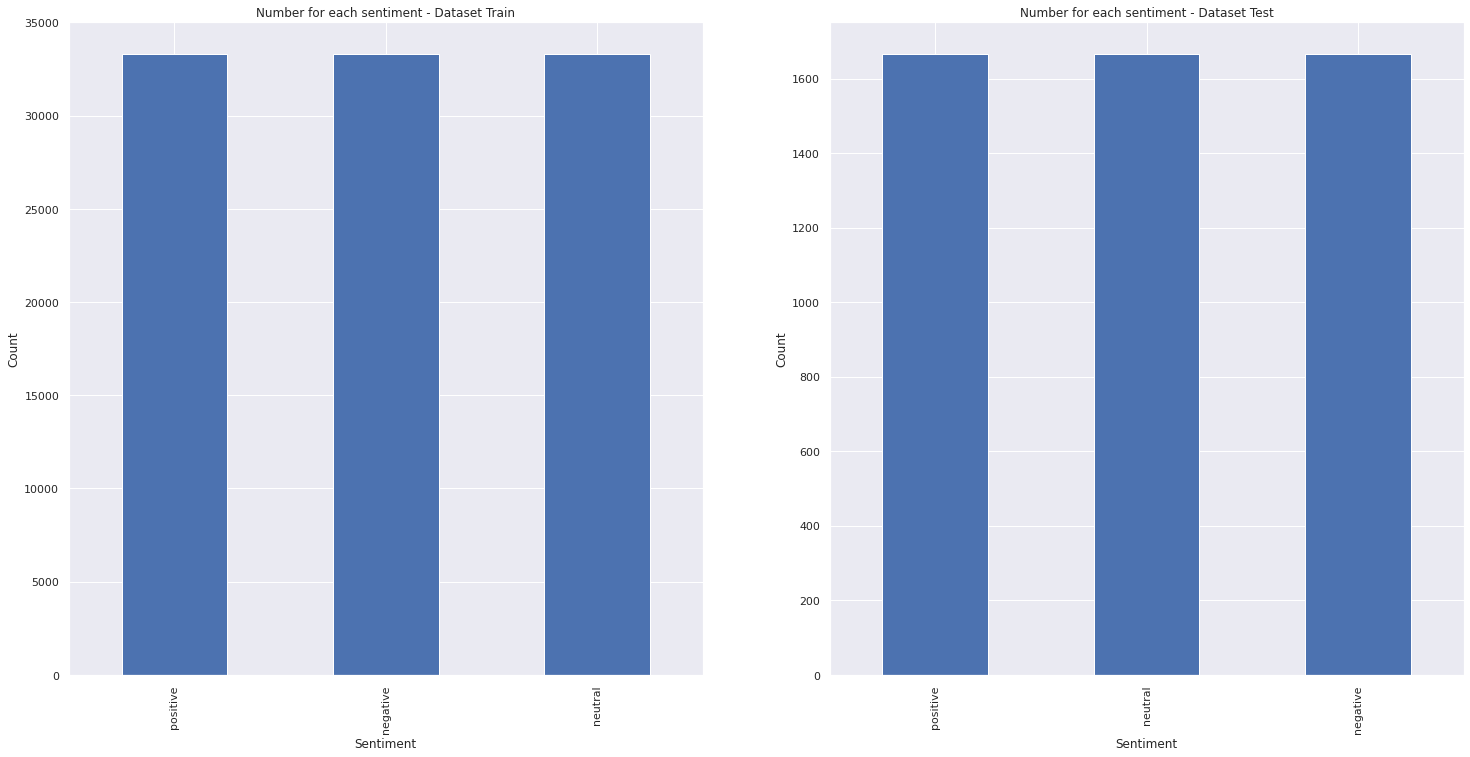

In [12]:
plt.subplot(1,2,1)
train.plot(kind='bar');
plt.title('Number for each sentiment - Dataset Train');
plt.xlabel('Sentiment')
plt.ylabel('Count');

plt.subplot(1,2,2)
test.plot(kind='bar');
plt.title('Number for each sentiment - Dataset Test');
plt.xlabel('Sentiment')
plt.ylabel('Count');

### 2.3.2 Analysis Variable "query used"

In [13]:
train1 = df.query_used.value_counts()
test1 = dft.query_used.value_counts()

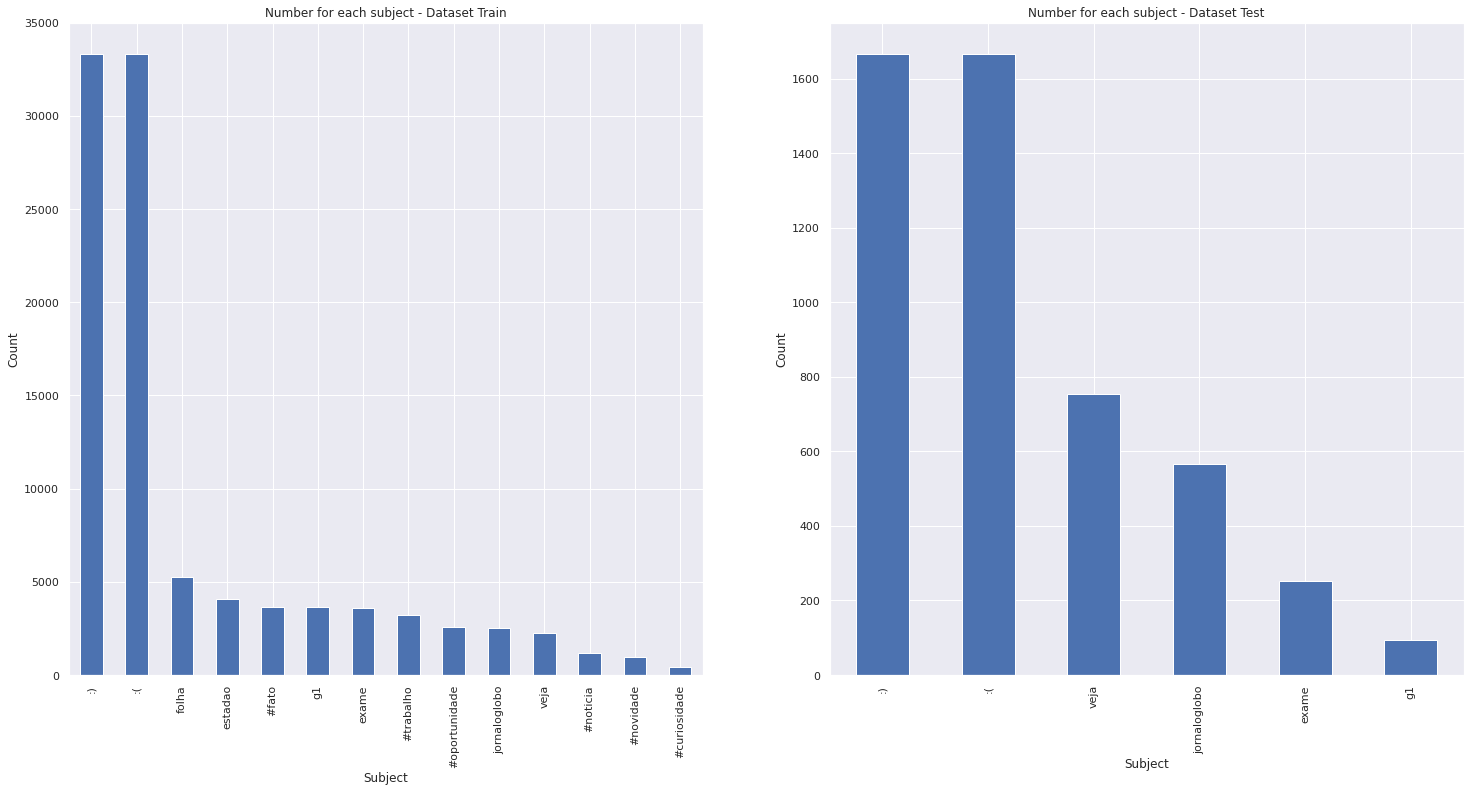

In [14]:
plt.subplot(1,2,1)
train1.plot(kind='bar');
plt.title('Number for each subject - Dataset Train');
plt.xlabel('Subject')
plt.ylabel('Count');

plt.subplot(1,2,2)
test1.plot(kind='bar');
plt.title('Number for each subject - Dataset Test');
plt.xlabel('Subject')
plt.ylabel('Count');

Observation:

- The two data sets contain some characters that may influence the model not performing well, requiring some data cleaning processes
 

## 2.4 Class Separation

In [15]:
# Dataset train
X_train = df['tweet_text']
y_train = df['sentiment']

# Dataset test
X_test = dft['tweet_text']

In [16]:
# Check dataset
for i in range(0,5):
    print(y_train[i], '->', X_train[i])

positive -> @Laranjito76 A pessoa certa para isso seria o vale e azevedo :)
positive -> @behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)
positive -> Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D
positive -> aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE
positive -> Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9


In [17]:
# Check dataset
for i in range(0,5):
    print(X_test[i])

@Gazo1a Nossa! Muito obrigada :)
@BerzGamer vai pa puta que te pariu :)
QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira no link ➔ https://t.co/jhh0Ttlpq3 | » Compartilhe! « Não encontrou a oferta ou cupom que procurava? Não se preocupe ;) criamos uma pagina com mais ofertas e cupons atualizada diariamente :) https://t.co/IgeeD0WmPf
EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR DE BUTERA. :) #MMVAs #iHeartRadioMMVAs #FFSingleNoTears https://t.co/ghZMLqRFiV
Estávamos em casa do Zé e eu estava a morrer de sono, chego a casa e fico sem sono :))))


# 3.0 Data Cleaning

## 3.1 Remove Urls

In [18]:
def RemoveUrl(df):
    ls = []
    words = ''
    remove1 = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    remove2 = re.compile('www?.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    for line in df:
        urls = remove1.findall(line)

        for u in urls:
            line = line.replace(u, ' ')

        urls = remove2.findall(line)

        for u in urls:
            line = line.replace(u, ' ')
            
        ls.append(line)
    return ls

In [19]:
X_train_url = RemoveUrl(X_train)
X_test_url = RemoveUrl(X_test)

## 3.2 Remove Regex Pattern

In [20]:
def RemoveRegex(data, regex_pattern):
    ls = []
    words = ''
    
    for line in data:
        matches = re.finditer(regex_pattern, line)
        
        for m in matches: 
            line = re.sub(m.group().strip(), '', line)

        ls.append(line)

    return ls

In [21]:
# Remove # of the text
regex_pattern ='#[\w]*'

X_train_re = RemoveRegex(X_train_url, regex_pattern)
X_test_re = RemoveRegex(X_test_url, regex_pattern)

#Remove @ of the text
regex_pattern1 ='@[\w]*'

X_train_reg = RemoveRegex(X_train_re, regex_pattern1)
X_test_reg = RemoveRegex(X_test_re, regex_pattern1)

## 3.3 Tokenização

In [22]:
def TokenizeText(df):
    ls = []

    for line in df:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

In [23]:
X_train_tokens = TokenizeText(X_train_reg)
X_test_tokens = TokenizeText(X_test_reg)

## 3.4 Standardization

In [24]:
def standardization(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [25]:
std_list = {'eh': 'é', 'vc': 'você', 
            'vcs': 'vocês','tb': 'também', 
            'tbm': 'também', 'obg': 'obrigado', 
            'gnt': 'gente', 'q': 'que', 
            'n': 'não', 'cmg': 'comigo', 
            'p': 'para', 'ta': 'está', 
            'to': 'estou', 'vdd': 'verdade','alg':'alguém', 'mt':'muito'}


In [26]:
X_train_std = standardization(X_train_tokens, std_list)
X_test_std = standardization(X_test_tokens, std_list)

## 3.5 Stopwords

In [27]:
list_stp = nltk.corpus.stopwords.words('portuguese')

In [28]:
def RemoveStopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [29]:
X_train_stop = RemoveStopwords(X_train_std,list_stp)
X_test_stop = RemoveStopwords(X_test_std,list_stp)

## 3.6 Untokenize text

In [30]:
def UntokenizeText(tokens):
    ls = []

    for tk_line in tokens:
        new_line = ''
        
        for word in tk_line:
            new_line += word + ' '
            
        ls.append(new_line)
        
    return ls

In [31]:
X_train_clean = UntokenizeText(X_train_stop)
X_test_clean = UntokenizeText(X_test_stop)

## 3.7 Check Dataset

In [32]:
# Check dataset after data cleaning
for i in range(0,5):
    print(y_train[i], '->', X_train_clean[i])

positive -> pessoa certa vale azevedo :) 
positive -> mim , precisamente contrário :) Vem chuva vem boa disposição :) 
positive -> Vou fazer video hoje ... pensando falar pouco sobre novo meta CSGO sobre pagina Alguem sugestao ? Queria falar sobre algo cenario nacional : D 
positive -> aaaaaaaa amei tanto polaroids , sei expressar quanto apaixonada verdade ✨💖🎈🎉🎊 espero outras pessoas consigam ganhar :) 
positive -> Valoriza coração menininho . diferente . faça sorrir ter certeza disso ❤️ — valorizo todo mundo vida , vai ser diferente :)) 


In [33]:
# Check dataset after data cleaning
for i in range(0,5):
    print(X_test_clean[i])

! obrigada :) 
vai pa puta pariu :) 
QUER DESCONTOS ? ( 14 / 08 ) ⭐⭐⭐⭐⭐ 🌐 Confira link ➔ | » Compartilhe ! « encontrou oferta cupom procurava ? preocupe ;) criamos pagina ofertas cupons atualizada diariamente :) 
VOU PEGAR , AJUDEM GALERA , AMOR BUTERA . :) 
casa Zé morrer sono , chego casa fico sono :)))) 


# 4.0 Models

## 4.1 Model Multinomial Naive Bayes

In [34]:
vectorizer = CountVectorizer(analyzer = "word")
X_train_vect= vectorizer.fit_transform(X_train_clean)

model_mnb = MultinomialNB()
model_mnb.fit(X_train_vect, y_train)

#Predict
predict = cross_val_predict(model_mnb, X_train_vect, y_train, cv = 10)

### 4.1.1 Model Metrics

In [35]:
metrics.accuracy_score(y_train, predict)

0.75851

In [36]:
# Model validation measures
sentiments = ['Positivo', 'Negativo','Neutro']
print(metrics.classification_report(y_train, predict))

              precision    recall  f1-score   support

    negative       0.71      0.77      0.74     33333
     neutral       0.89      0.85      0.87     33333
    positive       0.68      0.65      0.66     33334

    accuracy                           0.76    100000
   macro avg       0.76      0.76      0.76    100000
weighted avg       0.76      0.76      0.76    100000



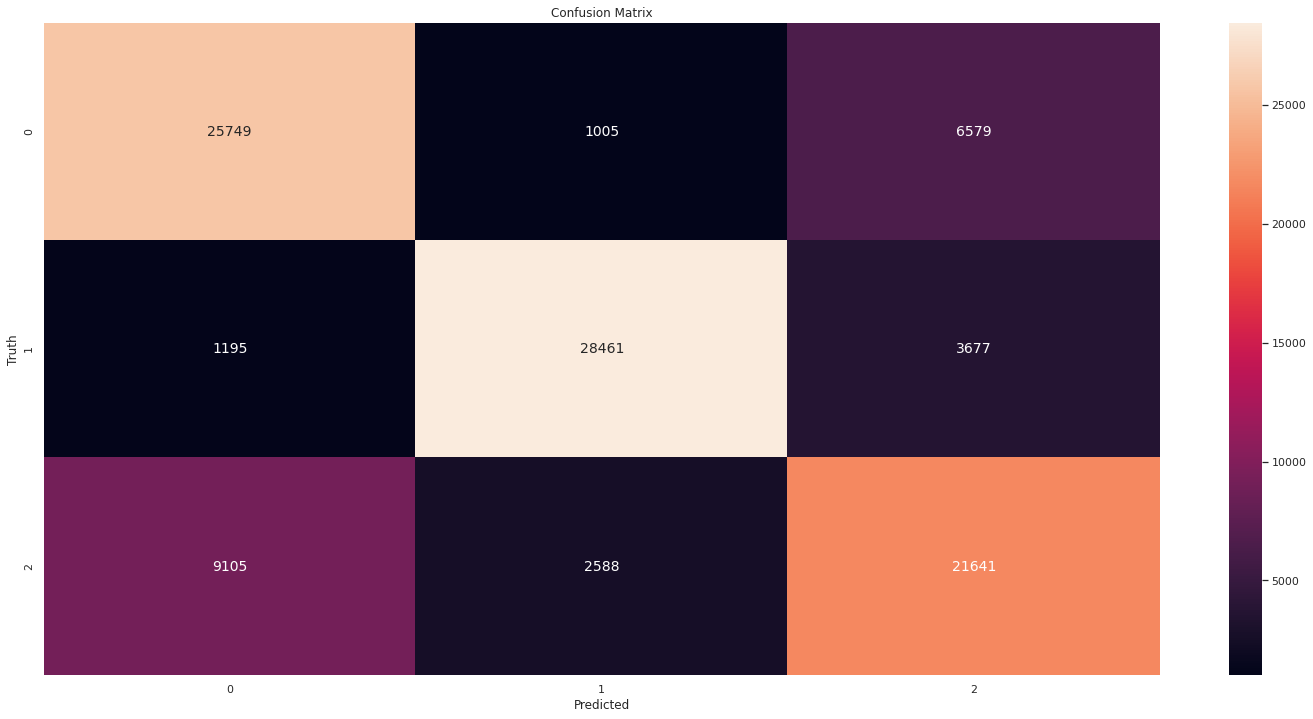

In [37]:
ax = sns.heatmap(confusion_matrix(y_train, predict), annot=True, fmt='d',annot_kws={"fontsize":14})
ax.set(xlabel='Predicted', ylabel='Truth', title='Confusion Matrix');

- The accuracy of the model is 75%.
- With the confusion matrix we can see that the model is performing well for a first cycle. We can see on the main diagonal that the model has a high hit rate.


# 5.0 Hyperparameters Model

In [38]:
vectorizer_cr = CountVectorizer(analyzer = "word", ngram_range = (1, 2))
X_train_cr = vectorizer.fit_transform(X_train)

model_mnb_cr= MultinomialNB()
model_mnb_cr.fit(X_train_cr, y_train)

# Prediction 
predict_cr = cross_val_predict(model_mnb_cr, X_train_cr, y_train, cv = 10)

## 5.1 Model Metrics

In [39]:
# New accuracy 
metrics.accuracy_score(y_train, predict_cr)

0.79155

In [40]:
# Model validation measures
sentiments = ['Positivo', 'Negativo','Neutro']
print(metrics.classification_report(y_train, predict_cr))

              precision    recall  f1-score   support

    negative       0.74      0.79      0.76     33333
     neutral       0.90      0.93      0.91     33333
    positive       0.73      0.66      0.69     33334

    accuracy                           0.79    100000
   macro avg       0.79      0.79      0.79    100000
weighted avg       0.79      0.79      0.79    100000



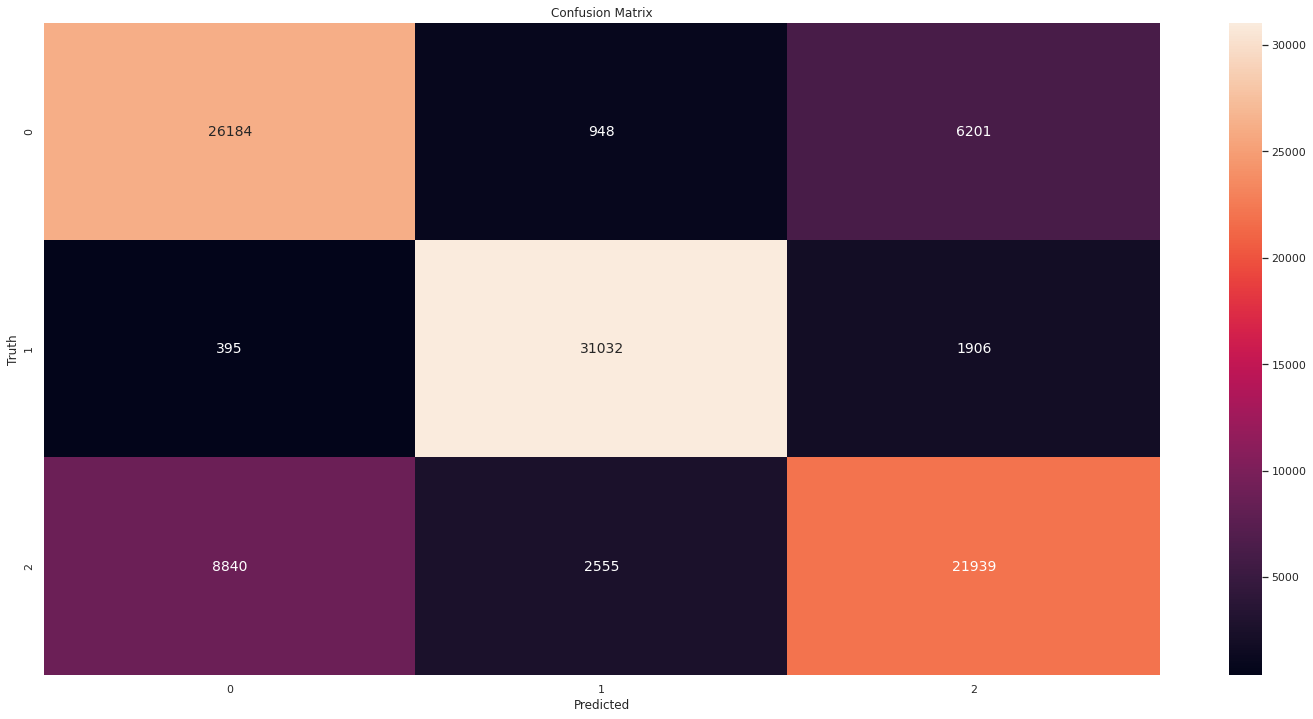

In [41]:
ax = sns.heatmap(confusion_matrix(y_train, predict_cr), annot=True, fmt='d',annot_kws={"fontsize":14})
ax.set(xlabel='Predicted', ylabel='Truth', title='Confusion Matrix');

Observation:

- With the modification of some model parameters there was a small improvement in accuracy from 75% to 79%
- We can verify with the confusion matrix that the model had more hits.

# 6.0  Test Model

In [42]:
def TestModel (data):
    X_vect = vectorizer.transform(data)
    std_predictions = model_mnb_cr.predict(X_vect)
    
    df = pd.DataFrame(data = {'Tweets': X_test_clean, 'Sentiment': std_predictions })
    return df.sample(4) 

In [43]:
TestModel(X_test_clean)

,Tweets,Sentiment
1405,"coloque , vai fique legal . : D",positive
3114,so queria livríneos Pedro Siqueira chegassem h...,negative
2658,"moro pais :(, boa sorte nene",positive
867,"Fala cansado , sdds Lara :)",negative


# 7.0 Conclusion 

- This model  accuracy is 79% after changing some parameters.
- A more detailed analysis can be done in the step of cleaning the data, such as interpreting the emoticons, include words in stopwords and checking some slang or abreviations in the messages.
- Another alternative is to change some parameters of the model used

# 8.0 Next steps

- Implement some cleaning techniques in the data such as removing emotions, adding words in the stopwords step and also in the standardization step.
- Change the parameters of the model used. Test with another classification model.
